<center><img src="http://sydney.edu.au/images/content/about/logo-mono.jpg"></center>

<center><h1>Statistical Learning and Data Mining (QBUS6810)</h1></center>
<center><h2>Tutorial 9: Regression Splines</h2></center>
<br>

In this tutorial we study how to implement regression splines and generalised additive models in Python.

<a class="buttom" href=">#Data:-customer-analytics">Data: Customer Analytics</a> <br>
<a class="buttom" href="#Exploratory-data-analysis">Exploratory data analysis</a> <br>
<a class="buttom" href="#Regression-splines">Regression splines</a> <br>
<a class="buttom" href="#Natural-splines">Natural splines</a> <br>
<a class="buttom" href="#Generalised-additive-model">Generalised additive model</a> <br>
<a class="buttom" href="#Model-evaluation">Model Evaluation</a> <br>
<a class="buttom" href="#Exercise">Exercise</a> <br>

This notebook relies on the following imports and settings.

In [1]:
# Packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
blue='#1F77B4'
%matplotlib inline

##Data: Customer Analytics

We again focus on customer analytics dataset from Tutorials 6 and 10.

In [3]:
data = pd.read_excel('CustomerAcquisition.xls', index_col=[0])
data.head(10)

,Acquisition,First_Purchase,CLV,Duration,Censor,Acq_Expense,Acq_Expense_SQ,Industry,Revenue,Employees,Ret_Expense,Ret_Expense_SQ,Crossbuy,Frequency,Frequency_SQ
Customer,,,,,,,,,,,,,,,
1,1,433.64,0.0000,384,0,760.36,578147.33,1,30.16,1240,2309.79,5335129.84,5,2,4
2,0,0.00,0.0000,0,0,147.70,21815.29,1,39.80,166,0.00,0.00,0,0,0
3,0,0.00,0.0000,0,0,252.56,63786.55,1,54.93,1016,0.00,0.00,0,0,0
4,1,225.84,5.7316,730,1,609.73,371770.67,1,45.83,122,2192.59,4807450.91,2,12,144
5,1,363.04,0.0000,579,0,672.36,452067.97,1,69.03,313,801.14,641825.30,4,7,49
6,0,0.00,0.0000,0,0,435.57,189721.22,0,22.54,359,0.00,0.00,0,0,0
7,0,0.00,0.0000,0,0,362.90,131696.41,0,32.97,902,0.00,0.00,0,0,0
8,0,0.00,0.0000,0,0,883.54,780642.93,0,22.48,264,0.00,0.00,0,0,0
9,1,599.30,6.9161,730,1,452.35,204620.52,1,17.98,1782,1340.75,1797610.56,1,11,121


Our first goal in this tutorial is to extend of customer lifetime value (CLV) analysis from Tutorial 6 to account for nonlinearities. We therefore process the dataset in a similar way.

In [4]:
data = data[data['Censor']==1] # our goal is to predict the CLV of retained customers, identified by Censor=1 

response = ['CLV']
predictors=['Acq_Expense', 'Ret_Expense', 'First_Purchase', 'Revenue', 'Employees', 'Crossbuy', 'Frequency', 'Industry']
    
data = data[response+predictors] # keeping only the variables that we are going to use

train = data.sample(frac=0.7, random_state=1)
test = data[data.index.isin(train.index)==False].copy()

X_train= train[predictors]
X_test= test[predictors]
y_train= train['CLV']
y_test= test['CLV']

##Exploratory data analysis

We start by computing the correlations between the response and the predictors as a reference for our analysis.

In [5]:
train.corr().round(3)[['CLV']]

,CLV
CLV,1.000
Acq_Expense,-0.425
Ret_Expense,0.411
First_Purchase,0.558
Revenue,0.123
Employees,0.543
Crossbuy,0.358
Frequency,-0.078
Industry,0.127


To explore possible nonlinearities in the data, we build scatter plots for all the numerical predictors. The scatter plots include local regression fits for visualisation. Nonlinear patters are apparent for several predictors, in particular the acquisition and retention expenses, customer revenue, and buying frequency. 

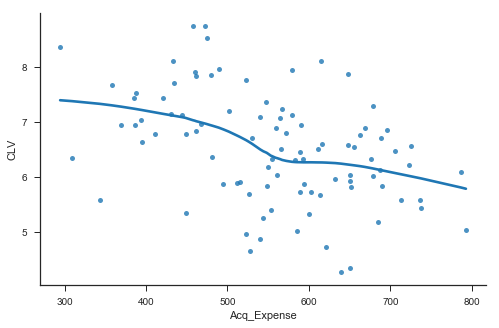

In [6]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['Acq_Expense'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=blue)
sns.despine()
fig.show()

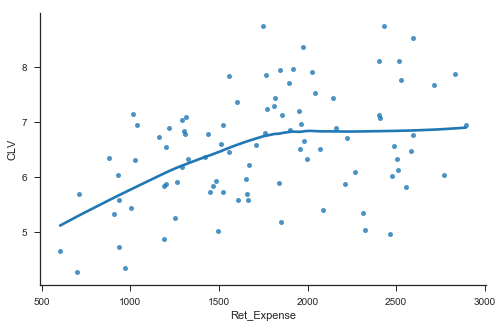

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['Ret_Expense'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=blue)
sns.despine()
fig.show()

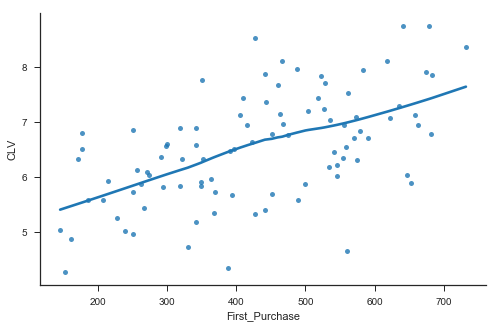

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['First_Purchase'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=blue)
sns.despine()
fig.show()

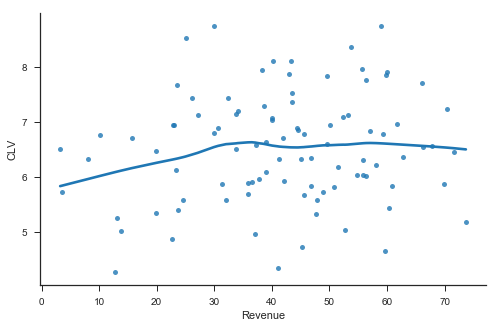

In [9]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['Revenue'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=blue)
sns.despine()
fig.show()

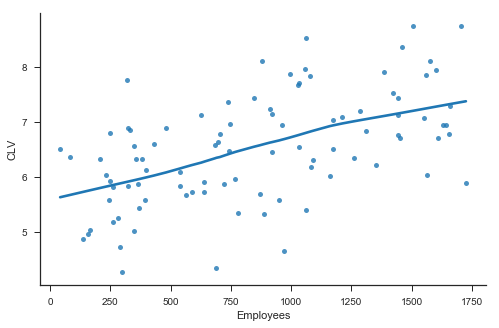

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['Employees'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=blue)
sns.despine()
fig.show()

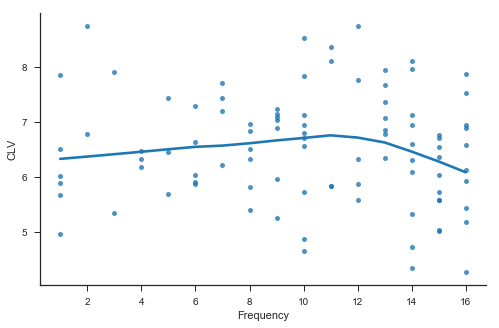

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['Frequency'], train['CLV'],  scatter_kws = {'s': 25}, lowess=True, color=blue)
sns.despine()
fig.show()

##Regression Splines

We use the [<TT>patsy</TT>](http://patsy.readthedocs.io/en/latest/index.html) library to construct spline expansions. Our implementation is based on two core functions: [<TT>dmatrix</TT>](http://patsy.readthedocs.io/en/latest/API-reference.html#patsy.dmatrix), the general design matrix constructor, and [<TT>bs</TT>](http://patsy.readthedocs.io/en/latest/API-reference.html#spline-regression), the building block for regression splines.

The next cell builds a linear basis expansion for a cubic spline (degree=3) with four degrees of freedom (df=4, therefore using one knot) for the retention expense. The function generates B-splines rather than the step functions we have seen in the lectures. B-splines generate an equivalent model, but lead to more numerically stable computations. 

In [12]:
from patsy import dmatrix

X = dmatrix('bs(predictor, degree=3, df=4) - 1', {'predictor': train['Ret_Expense']}, return_type='dataframe')
# The -1 excludes the intercept
X.head()

,"bs(predictor, degree=3, df=4)[0]","bs(predictor, degree=3, df=4)[1]","bs(predictor, degree=3, df=4)[2]","bs(predictor, degree=3, df=4)[3]"
Customer,,,,
126,0.318851,0.489163,0.191170,0.000000
103,0.391723,0.460276,0.142328,0.000000
330,0.031471,0.251704,0.595972,0.120853
17,0.009401,0.131247,0.569199,0.290153
216,0.164663,0.477499,0.356010,0.001828


Given the design matrix, we estimate the model by OLS. 

In [13]:
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
ols.fit(X, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
from patsy import build_design_matrices

a=train['Ret_Expense'].min()
b=train['Ret_Expense'].max()
x=np.linspace(a, b)

X_predict = build_design_matrices([X.design_info], {'predictor': x})[0] # remember that X is our original design matrix
y_fitted=ols.predict(X_predict)

Finally, we plot the regression fit. 

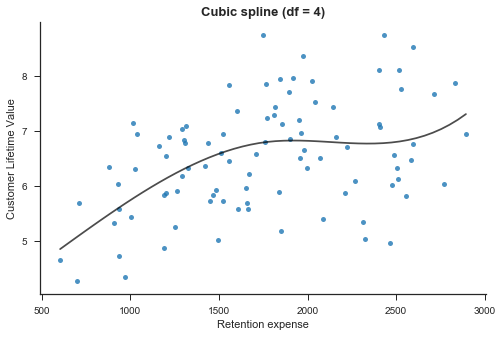

In [15]:
fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train['Ret_Expense'], y_train,  scatter_kws = {'s': 25}, fit_reg=False, color=blue)
ax.plot(x, y_fitted, color='Black', alpha=0.7)
ax.set_xlabel('Retention expense')
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Cubic spline (df = 4)', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

The next repeats all these steps for a linear spline with one knot. You should experiment by changing the first two lines to try different models (say, by adding more knots) and predictors.

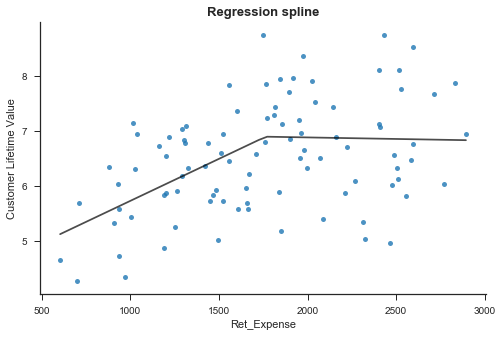

In [16]:
predictor = 'Ret_Expense'
X = dmatrix('bs(variable, degree=1, df=2) - 1', {'variable': train[predictor]}, return_type='dataframe')

ols = LinearRegression()
ols.fit(X, y_train)

a=train[predictor].min()
b=train[predictor].max()
x=np.linspace(a, b)

X_predict = build_design_matrices([X.design_info], {'variable': x})[0] # remember that X is our original design matrix
y_fitted=ols.predict(X_predict)

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train[predictor], y_train,  scatter_kws = {'s': 25}, fit_reg=False, color=blue)
ax.plot(x, y_fitted, color='Black', alpha=0.7)
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Regression spline', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

##Natural Splines

Estimating a natural cubic spline requires only a straightforward modification. 

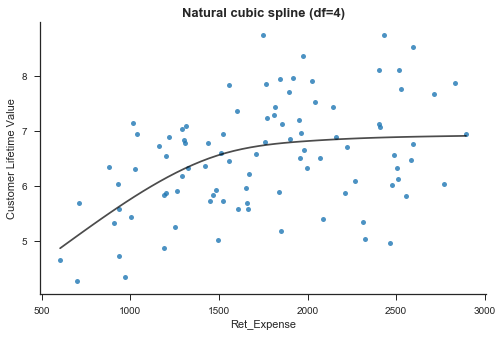

In [17]:
predictor = 'Ret_Expense'
X = dmatrix('cr(variable, df=4) - 1', {'variable': train[predictor]}, return_type='dataframe')

ols = LinearRegression()
ols.fit(X, y_train)

a=train[predictor].min()
b=train[predictor].max()
x=np.linspace(a, b)

X_predict = build_design_matrices([X.design_info], {'variable': x})[0] # remember that X is our original design matrix
y_fitted=ols.predict(X_predict)

fig, ax = plt.subplots(figsize=(8,5))
sns.regplot(train[predictor], y_train,  scatter_kws = {'s': 25}, fit_reg=False, color=blue)
ax.plot(x, y_fitted, color='Black', alpha=0.7)
ax.set_ylabel('Customer Lifetime Value')
ax.set_title('Natural cubic spline (df=4)', fontsize=13, fontweight='bold')

sns.despine()
plt.show()

##Generalised additive model

We implement a generalised regression based on naturals splines in the <TT>statlearning</TT> module. To fit the model, we build a dictionary to indicate the number of natural spline basis functions that we request for selected predictors.  All predictors not included in the dictionary are assumed to be linear.   

In [18]:
from statlearning import generalised_additive_regression

spline_dfs={'Ret_Expense': 4, 'Acq_Expense': 3, 'Frequency': 3, 'Employees': 4}

gam = generalised_additive_regression()
gam.fit(X_train, y_train, spline_dfs)

We use a backward selection algorithm to find the best specification by cross validation. First, we build a dictionary to specify the maximum degrees of freedom that we are going to consider for each predictor. Because the sample size is small, it is important to not set these numbers high as the selected model may overfit even if we are using cross validation. 

In [19]:
max_dfs = {} # initialising dictionary

# setting a maximum of two degrees of freedom for each numerical predictor

for predictor in  list(X_train.columns[:-1]): # looping over the list of numerical predictors
    max_dfs[predictor] = 2 

# allowing the acquisition and retention expenses specifically to have higher maximum degrees of freedom 

max_dfs['Acq_Expense'] = 3
max_dfs['Ret_Expense'] = 3

print(max_dfs)

{'Acq_Expense': 3, 'Ret_Expense': 3, 'First_Purchase': 2, 'Revenue': 2, 'Employees': 2, 'Crossbuy': 2, 'Frequency': 2}


The following syntax selects and fits the best specification according to leave one out cross validation.

In [20]:
gam = generalised_additive_regression()
gam.backward_selection(X_train, y_train, max_dfs, max_dfs_model=20)

gam.info()

Selected degrees of freedom (backward algorithm): 

Acq_Expense       3
Ret_Expense       3
First_Purchase    1
Revenue           1
Employees         0
Crossbuy          1
Frequency         2
Industry          1
dtype: int32


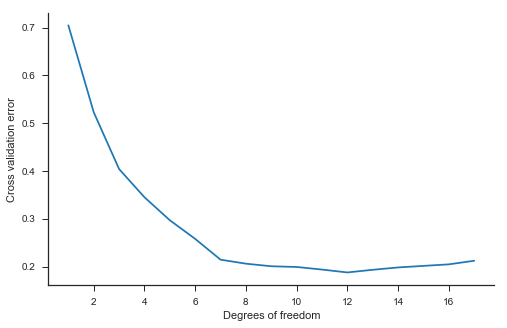

In [21]:
gam.plot_cv()
plt.show()

In certain cases, we may simply want to build the design matrices for the training and test sets.  The module supports this as follows.

In [22]:
from statlearning import gam_design_matrix, gam_design_matrix_test
X_train_gam = gam_design_matrix(X_train, spline_dfs)
X_train_gam, X_test_gam = gam_design_matrix_test(X_train, X_test, spline_dfs)

Note that we need to build the training and test matrices together because we to specify lower and upper bounds for the predictors. 

##Model evaluation

The test results show that accounting for nonlinear effects leads to substantial improvements in predictive accuracy relative to a linear regression. 

In [23]:
# Fitting the two models
ols = LinearRegression()
ols.fit(X_train, y_train)

columns=['Test RMSE', 'SE', 'Test R2', 'SE','Test MAE','SE']
rows=['OLS', 'GAM']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

from statlearning import rmse_jack, r2_jack, mae
methods=[ols, gam]

for i, method in enumerate(methods):

    y_pred=method.predict(X_test)
    
    results.iloc[i,0], results.iloc[i,1] = rmse_jack(y_test, y_pred)
    results.iloc[i,2], results.iloc[i,3] = r2_jack(y_test, y_pred)
    results.iloc[i,4], results.iloc[i,5] = mae(y_test, y_pred)

results.round(3)

,Test RMSE,SE,Test R2,SE,Test MAE,SE
OLS,0.457,0.037,0.730,0.095,0.399,0.035
GAM,0.367,0.035,0.826,0.064,0.306,0.032


##To do

For future versions of the tutorial: 

1. Implement smoothing splines.  

2. Plot the individual regression functions based on the estimated GAM. 

##Exercise

Using the setting of Tutorial 10 (classification models customer acquisition), build a logistic regression model based on regression splines and investigate whether it leads to improved accuracy for the test data. 